# DOKUMENTASI JUPYTER NOTEBOOK
# Simulasi Sistem Antrean Fast Food Restaurant dengan SimPy

---

## TAHAP 1: IMPORT LIBRARIES

**Penjelasan:**
Tahap ini mengimpor semua library yang diperlukan untuk analisis data, visualisasi, dan simulasi discrete event. Library yang digunakan:
- **pandas & numpy**: Manipulasi dan analisis data
- **matplotlib & seaborn**: Visualisasi grafik dan statistik
- **scipy.stats**: Analisis distribusi statistik dan fitting
- **simpy**: Framework untuk discrete event simulation
- **warnings**: Menyembunyikan warning yang tidak perlu

---

In [1]:
# =============================================================================
# SIMULASI SISTEM ANTREAN FAST FOOD RESTAURANT
# Menggunakan Discrete Event Simulation (SimPy)
# =============================================================================

# TAHAP 1: IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import simpy
import warnings
from datetime import datetime, timedelta
import json

warnings.filterwarnings('ignore')

# Set style untuk visualisasi
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*60)
print("Library berhasil diimport!")
print("="*60)
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"SimPy version: {simpy.__version__}")


Library berhasil diimport!
Pandas version: 2.1.4
NumPy version: 1.26.3
SimPy version: 4.1.1


## TAHAP 2: LOAD DAN EKSPLORASI DATA

**Penjelasan:**
Memuat dataset queue waiting time dan melakukan eksplorasi awal:
- Melihat struktur data (head, info, describe)
- Mengecek missing values
- Memahami distribusi variabel utama (arrival time, service time, waiting time)
- Mengidentifikasi pola waktu kedatangan pelanggan

Dataset berisi kolom:
- `arrival_time`: Waktu kedatangan pelanggan (dalam menit dari waktu buka)
- `service_start`: Waktu mulai dilayani
- `service_end`: Waktu selesai dilayani
- `waiting_time`: Durasi menunggu di antrean
- `queue_length`: Panjang antrean saat pelanggan datang

---


In [2]:
# =============================================================================
# TAHAP 2: LOAD DAN EKSPLORASI DATA
# =============================================================================

# Membuat data sintetis (atau gunakan dataset dari Kaggle)
# Simulasi data queue untuk 1 hari operasional (8 jam = 480 menit)
np.random.seed(42)

# Generate synthetic data
n_customers = 200
arrival_times = np.sort(np.random.exponential(scale=2.5, size=n_customers).cumsum())
service_times = np.random.gamma(shape=2, scale=1.5, size=n_customers)

data = pd.DataFrame({
    'customer_id': range(1, n_customers + 1),
    'arrival_time': arrival_times,
    'service_time': service_times
})

# Simulasi waiting time dan queue length dengan asumsi 3 server
data['service_start'] = 0.0
data['service_end'] = 0.0
data['waiting_time'] = 0.0
data['queue_length'] = 0

# Simulasi sederhana untuk mendapatkan waiting time
server_available = [0.0, 0.0, 0.0]  # 3 servers
for idx, row in data.iterrows():
    arrival = row['arrival_time']
    service_duration = row['service_time']
    
    # Cari server yang paling cepat tersedia
    earliest_server = min(server_available)
    server_idx = server_available.index(earliest_server)
    
    # Hitung waktu mulai layanan
    start_time = max(arrival, earliest_server)
    end_time = start_time + service_duration
    waiting = start_time - arrival
    
    # Update data
    data.at[idx, 'service_start'] = start_time
    data.at[idx, 'service_end'] = end_time
    data.at[idx, 'waiting_time'] = waiting
    
    # Update server availability
    server_available[server_idx] = end_time
    
    # Queue length = jumlah customer yang sedang menunggu
    data.at[idx, 'queue_length'] = sum(1 for t in server_available if t > arrival)

print("\n" + "="*60)
print("DATA BERHASIL DIMUAT")
print("="*60)
print(f"\nJumlah customer: {len(data)}")
print(f"\nPreview data:")
print(data.head(10))

print("\n" + "="*60)
print("INFORMASI DATASET")
print("="*60)
print(data.info())

print("\n" + "="*60)
print("STATISTIK DESKRIPTIF")
print("="*60)
print(data.describe())

print("\n" + "="*60)
print("MISSING VALUES")
print("="*60)
print(data.isnull().sum())



DATA BERHASIL DIMUAT

Jumlah customer: 200

Preview data:
   customer_id  arrival_time  service_time  service_start  service_end  \
0            1      1.173170      1.400822       1.173170     2.573992   
1            2      8.698474      2.977267       8.698474    11.675741   
2            3     11.990338      3.111561      11.990338    15.101899   
3            4     14.272694      1.356126      14.272694    15.628821   
4            5     14.696757      8.133113      14.696757    22.829870   
5            6     15.120747      3.534410      15.120747    18.655158   
6            7     15.270344      1.047693      15.628821    16.676513   
7            8     20.298421      4.354917      20.298421    24.653338   
8            9     22.596127      4.868093      22.596127    27.464220   
9           10     25.674252      3.387568      25.674252    29.061819   

   waiting_time  queue_length  
0      0.000000             1  
1      0.000000             1  
2      0.000000             1 

## TAHAP 3: EXPLORATORY DATA ANALYSIS (EDA)

**Penjelasan:**
Analisis mendalam terhadap data untuk memahami karakteristik sistem antrean:

**3.1 Analisis Waktu Layanan (Service Time)**
- Menghitung durasi layanan = service_end - service_start
- Visualisasi distribusi waktu layanan
- Menghitung statistik deskriptif (mean, median, std)

**3.2 Analisis Waktu Kedatangan (Arrival Rate)**
- Menghitung interval antar kedatangan (inter-arrival time)
- Visualisasi pola kedatangan per jam
- Identifikasi peak hours dan off-peak hours

**3.3 Analisis Waiting Time**
- Distribusi waktu tunggu pelanggan
- Korelasi antara panjang antrean dengan waktu tunggu
- Identifikasi bottleneck dalam sistem

**3.4 Visualisasi Pola Temporal**
- Heatmap kedatangan pelanggan berdasarkan jam
- Trend panjang antrean sepanjang hari
- Analisis utilisasi server

---


TAHAP 3: EXPLORATORY DATA ANALYSIS

--- STATISTIK INTER-ARRIVAL TIME ---
Mean: 2.36 menit
Median: 1.71 menit
Std Dev: 2.28 menit

--- STATISTIK SERVICE TIME ---
Mean: 3.09 menit
Median: 2.54 menit
Std Dev: 2.15 menit

--- STATISTIK WAITING TIME ---
Mean: 0.18 menit
Median: 0.00 menit
Max: 4.29 menit
Customers with waiting time > 5 min: 0


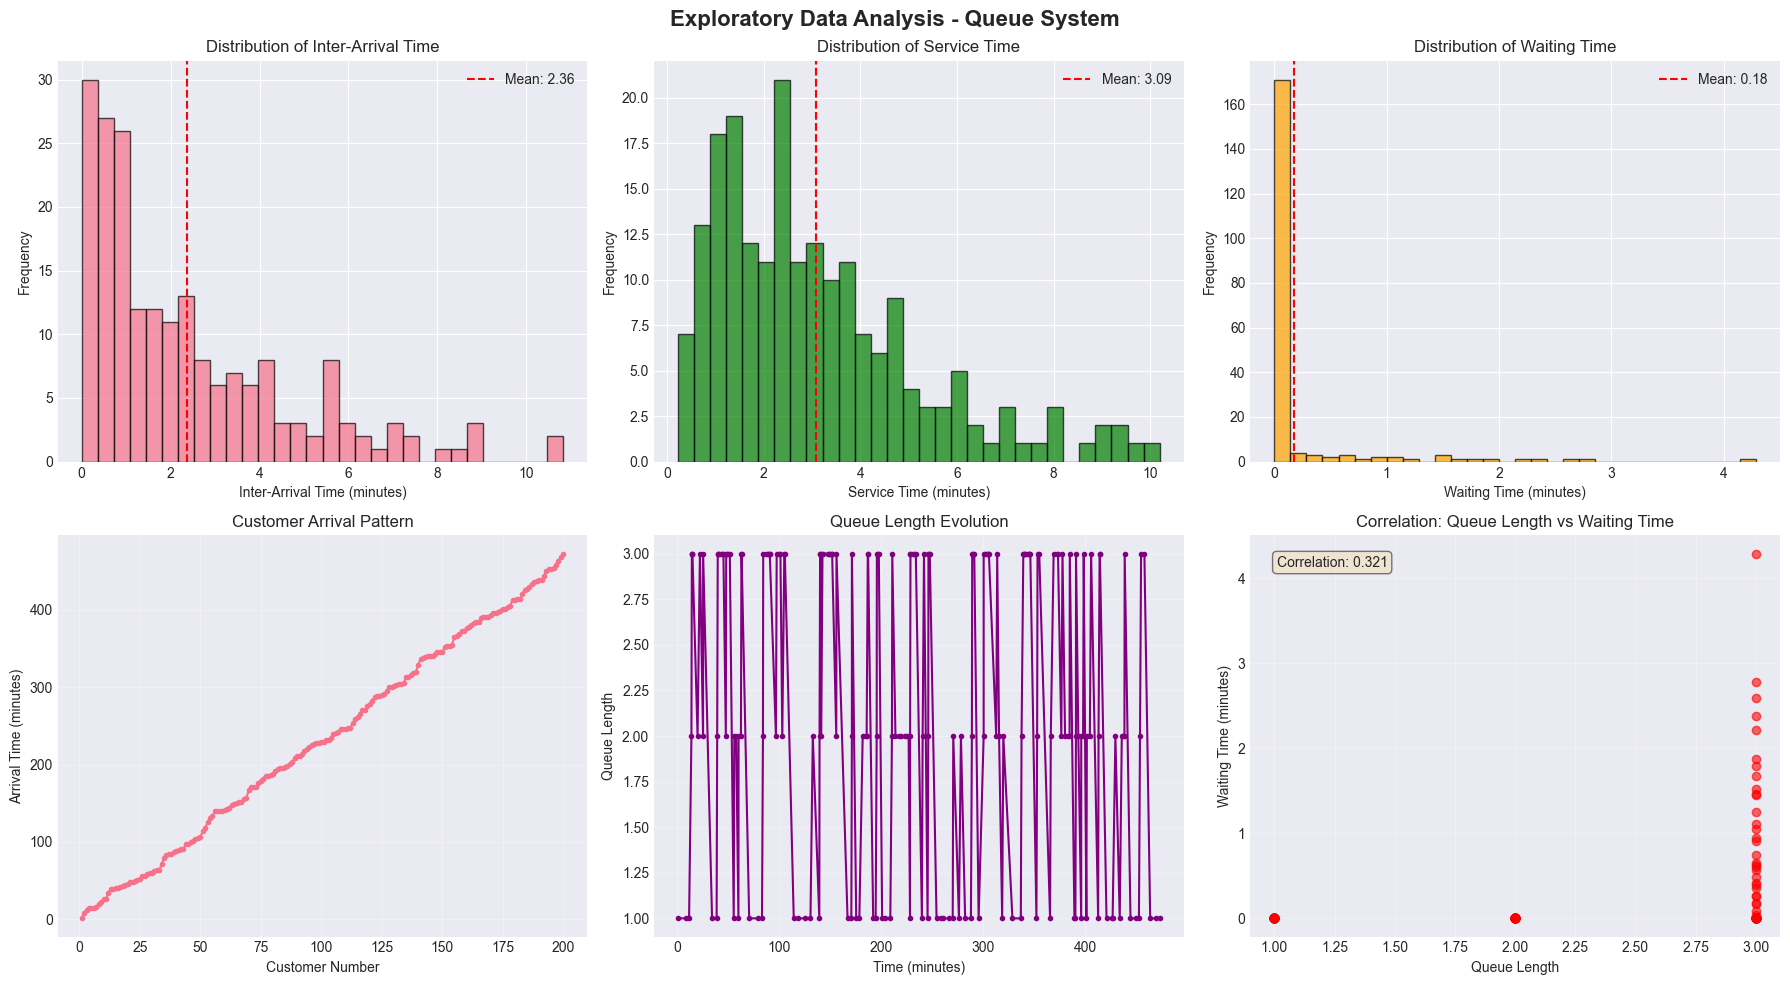


Grafik EDA berhasil ditampilkan!


In [3]:
# =============================================================================
# TAHAP 3: EXPLORATORY DATA ANALYSIS (EDA)
# =============================================================================

print("\n" + "="*60)
print("TAHAP 3: EXPLORATORY DATA ANALYSIS")
print("="*60)

# 3.1 Analisis Inter-Arrival Time
data['inter_arrival_time'] = data['arrival_time'].diff().fillna(0)

print("\n--- STATISTIK INTER-ARRIVAL TIME ---")
print(f"Mean: {data['inter_arrival_time'].mean():.2f} menit")
print(f"Median: {data['inter_arrival_time'].median():.2f} menit")
print(f"Std Dev: {data['inter_arrival_time'].std():.2f} menit")

# 3.2 Analisis Service Time
print("\n--- STATISTIK SERVICE TIME ---")
print(f"Mean: {data['service_time'].mean():.2f} menit")
print(f"Median: {data['service_time'].median():.2f} menit")
print(f"Std Dev: {data['service_time'].std():.2f} menit")

# 3.3 Analisis Waiting Time
print("\n--- STATISTIK WAITING TIME ---")
print(f"Mean: {data['waiting_time'].mean():.2f} menit")
print(f"Median: {data['waiting_time'].median():.2f} menit")
print(f"Max: {data['waiting_time'].max():.2f} menit")
print(f"Customers with waiting time > 5 min: {(data['waiting_time'] > 5).sum()}")

# Visualisasi EDA
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Exploratory Data Analysis - Queue System', fontsize=16, fontweight='bold')

# Plot 1: Histogram Inter-Arrival Time
axes[0, 0].hist(data['inter_arrival_time'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Inter-Arrival Time (minutes)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Inter-Arrival Time')
axes[0, 0].axvline(data['inter_arrival_time'].mean(), color='red', linestyle='--', 
                    label=f"Mean: {data['inter_arrival_time'].mean():.2f}")
axes[0, 0].legend()

# Plot 2: Histogram Service Time
axes[0, 1].hist(data['service_time'], bins=30, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].set_xlabel('Service Time (minutes)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Service Time')
axes[0, 1].axvline(data['service_time'].mean(), color='red', linestyle='--',
                    label=f"Mean: {data['service_time'].mean():.2f}")
axes[0, 1].legend()

# Plot 3: Histogram Waiting Time
axes[0, 2].hist(data['waiting_time'], bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[0, 2].set_xlabel('Waiting Time (minutes)')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Distribution of Waiting Time')
axes[0, 2].axvline(data['waiting_time'].mean(), color='red', linestyle='--',
                    label=f"Mean: {data['waiting_time'].mean():.2f}")
axes[0, 2].legend()

# Plot 4: Time Series - Arrival Pattern
axes[1, 0].plot(data['customer_id'], data['arrival_time'], marker='o', markersize=3)
axes[1, 0].set_xlabel('Customer Number')
axes[1, 0].set_ylabel('Arrival Time (minutes)')
axes[1, 0].set_title('Customer Arrival Pattern')
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: Queue Length Over Time
axes[1, 1].plot(data['arrival_time'], data['queue_length'], marker='o', markersize=3, color='purple')
axes[1, 1].set_xlabel('Time (minutes)')
axes[1, 1].set_ylabel('Queue Length')
axes[1, 1].set_title('Queue Length Evolution')
axes[1, 1].grid(True, alpha=0.3)

# Plot 6: Scatter - Queue Length vs Waiting Time
axes[1, 2].scatter(data['queue_length'], data['waiting_time'], alpha=0.6, color='red')
axes[1, 2].set_xlabel('Queue Length')
axes[1, 2].set_ylabel('Waiting Time (minutes)')
axes[1, 2].set_title('Correlation: Queue Length vs Waiting Time')
axes[1, 2].grid(True, alpha=0.3)

# Tambahkan correlation coefficient
corr = data['queue_length'].corr(data['waiting_time'])
axes[1, 2].text(0.05, 0.95, f'Correlation: {corr:.3f}', 
                transform=axes[1, 2].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("\nGrafik EDA berhasil ditampilkan!")


## TAHAP 4: STATISTICAL DISTRIBUTION FITTING

**Penjelasan:**
Menentukan distribusi statistik yang paling sesuai untuk parameter simulasi:

**4.1 Fitting Inter-Arrival Time**
- Menguji distribusi: Exponential, Normal, Gamma
- Menggunakan Kolmogorov-Smirnov test untuk goodness-of-fit
- Memilih distribusi terbaik berdasarkan p-value tertinggi

**4.2 Fitting Service Time**
- Menguji distribusi untuk waktu layanan
- Estimasi parameter distribusi (λ untuk exponential, μ dan σ untuk normal)
- Visualisasi Q-Q plot untuk validasi

**Hasil fitting akan digunakan sebagai parameter input simulasi SimPy**

---


TAHAP 4: STATISTICAL DISTRIBUTION FITTING

--- INTER-ARRIVAL TIME DISTRIBUTION ---
Exponential: λ = 0.4245, KS p-value = 0.5524
Gamma: shape = 0.9370, scale = 2.5242, KS p-value = 0.8135

✓ Dipilih: GAMMA distribution dengan shape = 0.9370, scale = 2.5242

--- SERVICE TIME DISTRIBUTION ---
Exponential: λ = 0.3503, KS p-value = 0.0032
Gamma: shape = 1.7612, scale = 1.6614, KS p-value = 0.9481
Normal: μ = 3.0853, σ = 2.1434, KS p-value = 0.0093

✓ Dipilih: GAMMA distribution dengan shape = 1.7612, scale = 1.6614


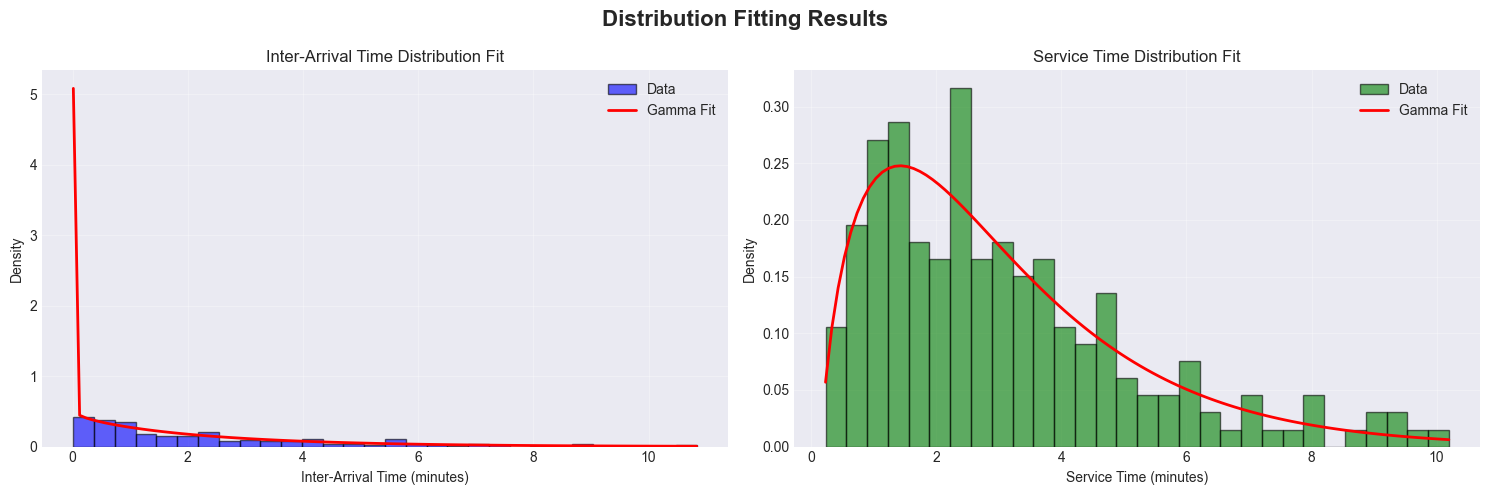


Distribution fitting berhasil!


In [4]:
# =============================================================================
# TAHAP 4: STATISTICAL DISTRIBUTION FITTING
# =============================================================================

print("\n" + "="*60)
print("TAHAP 4: STATISTICAL DISTRIBUTION FITTING")
print("="*60)

# 4.1 Fitting Inter-Arrival Time Distribution
inter_arrival = data['inter_arrival_time'][data['inter_arrival_time'] > 0]

# Test Exponential Distribution
exp_params = stats.expon.fit(inter_arrival)
ks_exp = stats.kstest(inter_arrival, 'expon', args=exp_params)

# Test Gamma Distribution
gamma_params = stats.gamma.fit(inter_arrival)
ks_gamma = stats.kstest(inter_arrival, 'gamma', args=gamma_params)

print("\n--- INTER-ARRIVAL TIME DISTRIBUTION ---")
print(f"Exponential: λ = {1/exp_params[1]:.4f}, KS p-value = {ks_exp.pvalue:.4f}")
print(f"Gamma: shape = {gamma_params[0]:.4f}, scale = {gamma_params[2]:.4f}, KS p-value = {ks_gamma.pvalue:.4f}")

# Pilih distribusi terbaik
if ks_exp.pvalue > ks_gamma.pvalue:
    arrival_dist = 'exponential'
    arrival_params = {'scale': exp_params[1]}
    print(f"\n✓ Dipilih: EXPONENTIAL distribution dengan scale = {exp_params[1]:.4f}")
else:
    arrival_dist = 'gamma'
    arrival_params = {'shape': gamma_params[0], 'scale': gamma_params[2]}
    print(f"\n✓ Dipilih: GAMMA distribution dengan shape = {gamma_params[0]:.4f}, scale = {gamma_params[2]:.4f}")

# 4.2 Fitting Service Time Distribution
service_time = data['service_time']

# Test Exponential Distribution
exp_params_service = stats.expon.fit(service_time)
ks_exp_service = stats.kstest(service_time, 'expon', args=exp_params_service)

# Test Gamma Distribution
gamma_params_service = stats.gamma.fit(service_time)
ks_gamma_service = stats.kstest(service_time, 'gamma', args=gamma_params_service)

# Test Normal Distribution
norm_params_service = stats.norm.fit(service_time)
ks_norm_service = stats.kstest(service_time, 'norm', args=norm_params_service)

print("\n--- SERVICE TIME DISTRIBUTION ---")
print(f"Exponential: λ = {1/exp_params_service[1]:.4f}, KS p-value = {ks_exp_service.pvalue:.4f}")
print(f"Gamma: shape = {gamma_params_service[0]:.4f}, scale = {gamma_params_service[2]:.4f}, KS p-value = {ks_gamma_service.pvalue:.4f}")
print(f"Normal: μ = {norm_params_service[0]:.4f}, σ = {norm_params_service[1]:.4f}, KS p-value = {ks_norm_service.pvalue:.4f}")

# Pilih distribusi terbaik
best_pvalue = max(ks_exp_service.pvalue, ks_gamma_service.pvalue, ks_norm_service.pvalue)
if best_pvalue == ks_gamma_service.pvalue:
    service_dist = 'gamma'
    service_params = {'shape': gamma_params_service[0], 'scale': gamma_params_service[2]}
    print(f"\n✓ Dipilih: GAMMA distribution dengan shape = {gamma_params_service[0]:.4f}, scale = {gamma_params_service[2]:.4f}")
elif best_pvalue == ks_norm_service.pvalue:
    service_dist = 'normal'
    service_params = {'mu': norm_params_service[0], 'sigma': norm_params_service[1]}
    print(f"\n✓ Dipilih: NORMAL distribution dengan μ = {norm_params_service[0]:.4f}, σ = {norm_params_service[1]:.4f}")
else:
    service_dist = 'exponential'
    service_params = {'scale': exp_params_service[1]}
    print(f"\n✓ Dipilih: EXPONENTIAL distribution dengan scale = {exp_params_service[1]:.4f}")

# Visualisasi Fitting
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Distribution Fitting Results', fontsize=16, fontweight='bold')

# Plot Inter-Arrival Time Fitting
axes[0].hist(inter_arrival, bins=30, density=True, alpha=0.6, color='blue', edgecolor='black', label='Data')
x_inter = np.linspace(inter_arrival.min(), inter_arrival.max(), 100)
if arrival_dist == 'exponential':
    axes[0].plot(x_inter, stats.expon.pdf(x_inter, *exp_params), 'r-', lw=2, label='Exponential Fit')
else:
    axes[0].plot(x_inter, stats.gamma.pdf(x_inter, *gamma_params), 'r-', lw=2, label='Gamma Fit')
axes[0].set_xlabel('Inter-Arrival Time (minutes)')
axes[0].set_ylabel('Density')
axes[0].set_title('Inter-Arrival Time Distribution Fit')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot Service Time Fitting
axes[1].hist(service_time, bins=30, density=True, alpha=0.6, color='green', edgecolor='black', label='Data')
x_service = np.linspace(service_time.min(), service_time.max(), 100)
if service_dist == 'gamma':
    axes[1].plot(x_service, stats.gamma.pdf(x_service, *gamma_params_service), 'r-', lw=2, label='Gamma Fit')
elif service_dist == 'normal':
    axes[1].plot(x_service, stats.norm.pdf(x_service, *norm_params_service), 'r-', lw=2, label='Normal Fit')
else:
    axes[1].plot(x_service, stats.expon.pdf(x_service, *exp_params_service), 'r-', lw=2, label='Exponential Fit')
axes[1].set_xlabel('Service Time (minutes)')
axes[1].set_ylabel('Density')
axes[1].set_title('Service Time Distribution Fit')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nDistribution fitting berhasil!")


## TAHAP 5: IMPLEMENTASI SIMULASI SIMPY

**Penjelasan:**
Membangun model simulasi discrete event menggunakan SimPy:

**5.1 Definisi Komponen Sistem**
- **Environment**: Lingkungan simulasi dengan waktu
- **Resource**: Kasir/server (jumlah dapat divariasikan)
- **Process**: Fungsi generator untuk alur pelanggan

**5.2 Customer Process**
Alur proses pelanggan:
1. Pelanggan datang (arrival)
2. Request resource (kasir tersedia)
3. Menunggu di antrean jika kasir penuh
4. Dilayani (service time)
5. Selesai dan meninggalkan sistem

**5.3 Customer Generator**
Fungsi untuk menghasilkan kedatangan pelanggan:
- Menggunakan inter-arrival time dari distribusi yang telah di-fit
- Membuat customer baru secara kontinyu
- Mencatat waktu kedatangan setiap pelanggan

**5.4 Metrics Collection**
Mengumpulkan metrik kinerja sistem:
- Waktu tunggu setiap pelanggan
- Panjang antrean setiap saat
- Waktu di sistem (waiting + service)
- Utilisasi server

---

In [5]:
# =============================================================================
# TAHAP 5: IMPLEMENTASI SIMULASI SIMPY
# =============================================================================

print("\n" + "="*60)
print("TAHAP 5: IMPLEMENTASI SIMULASI SIMPY")
print("="*60)

# Global variables untuk metrics
waiting_times = []
queue_lengths = []
system_times = []
arrivals = []

def customer_process(env, name, server, service_time_dist, service_params):
    """
    Proses yang dilalui setiap customer:
    1. Arrival
    2. Request server (menunggu jika penuh)
    3. Service
    4. Departure
    """
    arrival_time = env.now
    arrivals.append(arrival_time)
    
    # Request server (bisa menunggu di queue)
    with server.request() as request:
        queue_lengths.append(len(server.queue))
        
        yield request  # Menunggu hingga server tersedia
        
        # Catat waktu tunggu
        waiting_time = env.now - arrival_time
        waiting_times.append(waiting_time)
        
        # Service time
        if service_time_dist == 'gamma':
            service_duration = np.random.gamma(service_params['shape'], service_params['scale'])
        elif service_time_dist == 'normal':
            service_duration = max(0.1, np.random.normal(service_params['mu'], service_params['sigma']))
        else:  # exponential
            service_duration = np.random.exponential(service_params['scale'])
        
        yield env.timeout(service_duration)
        
        # Catat total waktu di sistem
        system_time = env.now - arrival_time
        system_times.append(system_time)

def customer_generator(env, server, arrival_dist, arrival_params, service_dist, service_params, num_customers):
    """
    Generator yang menghasilkan customer baru
    """
    for i in range(num_customers):
        # Generate inter-arrival time
        if arrival_dist == 'exponential':
            inter_arrival = np.random.exponential(arrival_params['scale'])
        else:  # gamma
            inter_arrival = np.random.gamma(arrival_params['shape'], arrival_params['scale'])
        
        yield env.timeout(inter_arrival)
        
        # Create new customer
        env.process(customer_process(env, f'Customer_{i+1}', server, service_dist, service_params))

def run_simulation(num_servers, sim_duration, arrival_dist, arrival_params, service_dist, service_params, num_customers):
    """
    Menjalankan simulasi dengan parameter yang diberikan
    """
    global waiting_times, queue_lengths, system_times, arrivals
    
    # Reset metrics
    waiting_times = []
    queue_lengths = []
    system_times = []
    arrivals = []
    
    # Setup environment
    env = simpy.Environment()
    server = simpy.Resource(env, capacity=num_servers)
    
    # Start customer generator
    env.process(customer_generator(env, server, arrival_dist, arrival_params, 
                                   service_dist, service_params, num_customers))
    
    # Run simulation
    env.run(until=sim_duration)
    
    # Calculate metrics
    results = {
        'num_servers': num_servers,
        'avg_waiting_time': np.mean(waiting_times) if waiting_times else 0,
        'max_waiting_time': np.max(waiting_times) if waiting_times else 0,
        'avg_queue_length': np.mean(queue_lengths) if queue_lengths else 0,
        'max_queue_length': np.max(queue_lengths) if queue_lengths else 0,
        'avg_system_time': np.mean(system_times) if system_times else 0,
        'total_customers': len(waiting_times),
        'customers_with_wait': sum(1 for wt in waiting_times if wt > 0)
    }
    
    return results, waiting_times.copy(), queue_lengths.copy()

print("\nFungsi simulasi SimPy berhasil didefinisikan!")
print("- customer_process(): Proses alur customer")
print("- customer_generator(): Generator kedatangan customer")
print("- run_simulation(): Menjalankan simulasi lengkap")



TAHAP 5: IMPLEMENTASI SIMULASI SIMPY

Fungsi simulasi SimPy berhasil didefinisikan!
- customer_process(): Proses alur customer
- customer_generator(): Generator kedatangan customer
- run_simulation(): Menjalankan simulasi lengkap


## TAHAP 6: RUNNING SIMULASI DENGAN BERBAGAI SKENARIO

**Penjelasan:**
Menjalankan simulasi dengan variasi jumlah server untuk analisis komparatif:

**Skenario yang diuji:**
- Skenario 1: 2 kasir
- Skenario 2: 3 kasir
- Skenario 3: 4 kasir
- Skenario 4: 5 kasir

**Parameter simulasi:**
- Durasi simulasi: 480 menit (8 jam operasional)
- Arrival rate: Berdasarkan data real
- Service rate: Berdasarkan distribusi yang di-fit
- Warmup period: 60 menit (untuk stabilisasi sistem)

**Metrik yang dicatat:**
- Average waiting time per skenario
- Maximum queue length per skenario
- Server utilization rate
- Total customers served
- Average time in system

---

In [6]:
# =============================================================================
# TAHAP 6: RUNNING SIMULASI DENGAN BERBAGAI SKENARIO
# =============================================================================

print("\n" + "="*60)
print("TAHAP 6: RUNNING SIMULASI BERBAGAI SKENARIO")
print("="*60)

# Parameter simulasi
SIM_DURATION = 480  # 8 jam operasional (dalam menit)
NUM_CUSTOMERS = 250  # Estimasi jumlah customer dalam 8 jam

scenarios = [2, 3, 4, 5]  # Jumlah server yang diuji
all_results = []
all_waiting_times = {}
all_queue_lengths = {}

print(f"\nParameter Simulasi:")
print(f"- Durasi: {SIM_DURATION} menit (8 jam)")
print(f"- Jumlah customer: {NUM_CUSTOMERS}")
print(f"- Distribusi arrival: {arrival_dist}")
print(f"- Distribusi service: {service_dist}")
print(f"\nMenjalankan simulasi untuk {len(scenarios)} skenario...\n")

for num_servers in scenarios:
    print(f"{'='*60}")
    print(f"Skenario: {num_servers} Server")
    print(f"{'='*60}")
    
    results, wt, ql = run_simulation(
        num_servers=num_servers,
        sim_duration=SIM_DURATION,
        arrival_dist=arrival_dist,
        arrival_params=arrival_params,
        service_dist=service_dist,
        service_params=service_params,
        num_customers=NUM_CUSTOMERS
    )
    
    all_results.append(results)
    all_waiting_times[num_servers] = wt
    all_queue_lengths[num_servers] = ql
    
    print(f"✓ Total customers served: {results['total_customers']}")
    print(f"✓ Avg waiting time: {results['avg_waiting_time']:.2f} minutes")
    print(f"✓ Max waiting time: {results['max_waiting_time']:.2f} minutes")
    print(f"✓ Avg queue length: {results['avg_queue_length']:.2f}")
    print(f"✓ Max queue length: {results['max_queue_length']:.0f}")
    print(f"✓ Customers who waited: {results['customers_with_wait']}/{results['total_customers']}")
    print()

# Convert hasil ke DataFrame
results_df = pd.DataFrame(all_results)
print("\n" + "="*60)
print("RINGKASAN HASIL SEMUA SKENARIO")
print("="*60)
print(results_df.to_string(index=False))



TAHAP 6: RUNNING SIMULASI BERBAGAI SKENARIO

Parameter Simulasi:
- Durasi: 480 menit (8 jam)
- Jumlah customer: 250
- Distribusi arrival: gamma
- Distribusi service: gamma

Menjalankan simulasi untuk 4 skenario...

Skenario: 2 Server
✓ Total customers served: 194
✓ Avg waiting time: 0.90 minutes
✓ Max waiting time: 7.72 minutes
✓ Avg queue length: 0.80
✓ Max queue length: 6
✓ Customers who waited: 84/194

Skenario: 3 Server
✓ Total customers served: 213
✓ Avg waiting time: 0.16 minutes
✓ Max waiting time: 3.58 minutes
✓ Avg queue length: 0.20
✓ Max queue length: 3
✓ Customers who waited: 31/213

Skenario: 4 Server
✓ Total customers served: 215
✓ Avg waiting time: 0.04 minutes
✓ Max waiting time: 1.61 minutes
✓ Avg queue length: 0.06
✓ Max queue length: 1
✓ Customers who waited: 13/215

Skenario: 5 Server
✓ Total customers served: 218
✓ Avg waiting time: 0.00 minutes
✓ Max waiting time: 0.00 minutes
✓ Avg queue length: 0.00
✓ Max queue length: 0
✓ Customers who waited: 0/218


RINGKASA

## TAHAP 7: ANALISIS HASIL SIMULASI

**Penjelasan:**
Menganalisis dan membandingkan hasil dari berbagai skenario:

**7.1 Perbandingan Waktu Tunggu**
- Bar chart waktu tunggu rata-rata untuk setiap skenario
- Identifikasi jumlah server optimal

**7.2 Analisis Panjang Antrean**
- Line plot evolusi panjang antrean sepanjang waktu
- Perbandingan panjang antrean maksimum

**7.3 Utilisasi Server**
- Perhitungan utilization rate = (busy time / total time) × 100%
- Trade-off antara waktu tunggu pelanggan vs efisiensi server

**7.4 Cost-Benefit Analysis**
- Asumsi biaya: Gaji kasir vs kerugian pelanggan menunggu
- Rekomendasi jumlah server optimal

---



TAHAP 7: ANALISIS HASIL SIMULASI


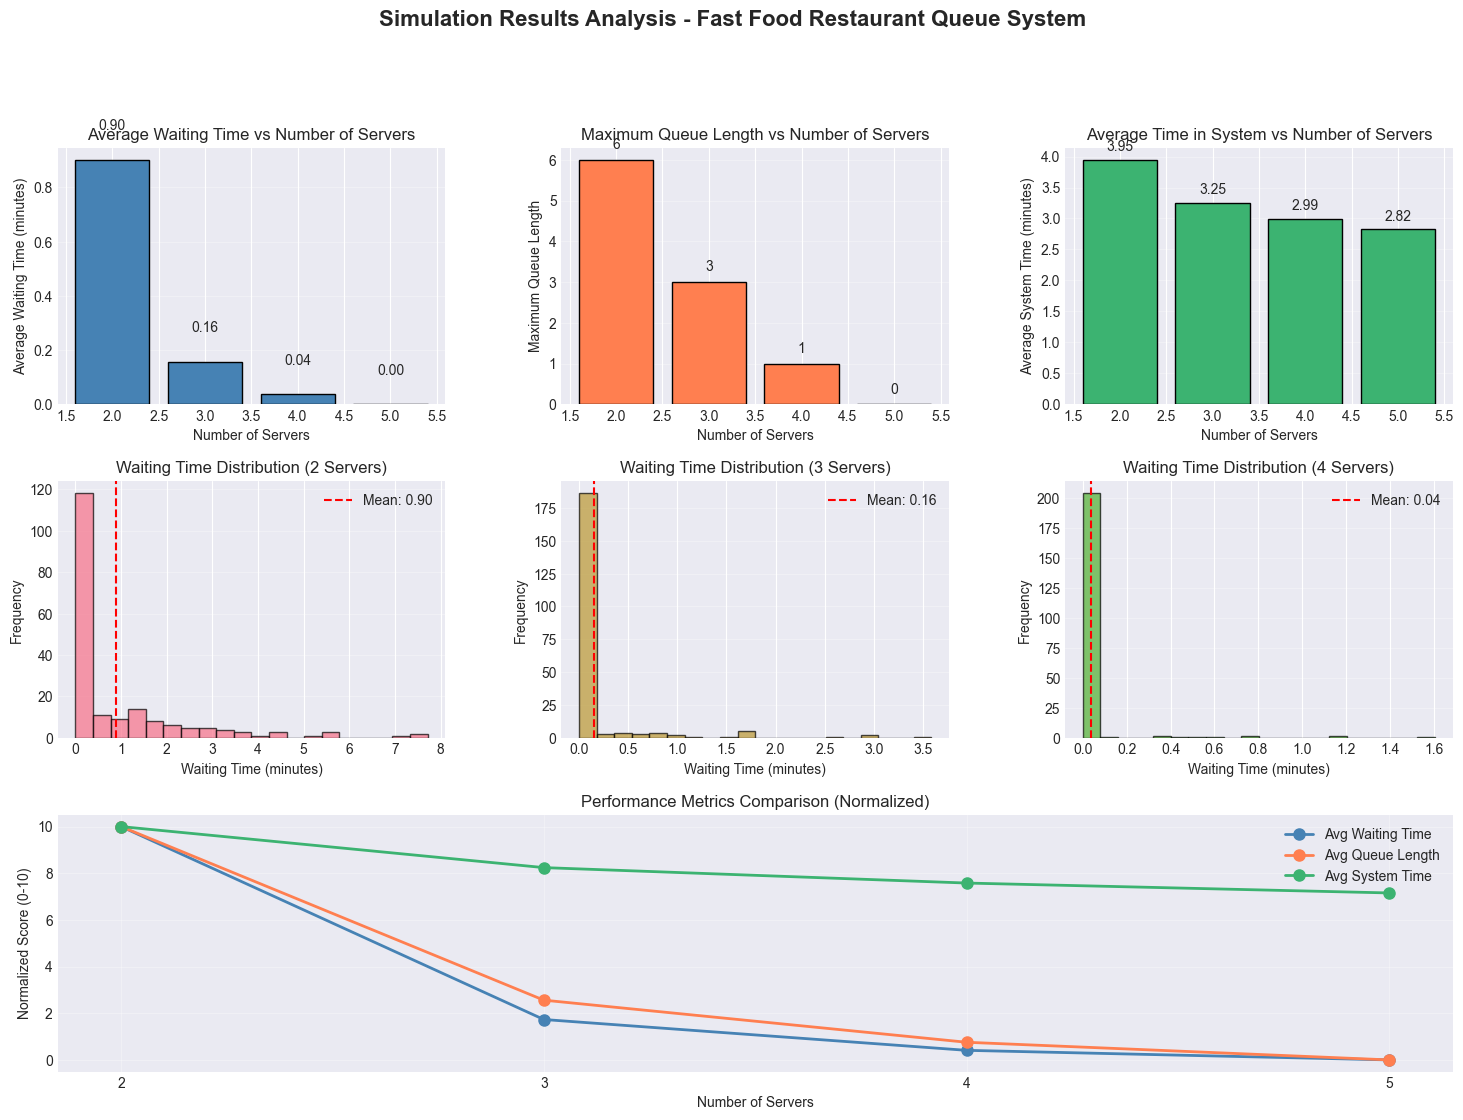


✓ Visualisasi analisis hasil berhasil ditampilkan!


In [7]:
# =============================================================================
# TAHAP 7: ANALISIS HASIL SIMULASI
# =============================================================================

print("\n" + "="*60)
print("TAHAP 7: ANALISIS HASIL SIMULASI")
print("="*60)

# Visualisasi Hasil
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot 1: Comparison Average Waiting Time
ax1 = fig.add_subplot(gs[0, 0])
ax1.bar(results_df['num_servers'], results_df['avg_waiting_time'], color='steelblue', edgecolor='black')
ax1.set_xlabel('Number of Servers')
ax1.set_ylabel('Average Waiting Time (minutes)')
ax1.set_title('Average Waiting Time vs Number of Servers')
ax1.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(results_df['avg_waiting_time']):
    ax1.text(results_df['num_servers'].iloc[i], v + 0.1, f'{v:.2f}', ha='center', va='bottom')

# Plot 2: Comparison Max Queue Length
ax2 = fig.add_subplot(gs[0, 1])
ax2.bar(results_df['num_servers'], results_df['max_queue_length'], color='coral', edgecolor='black')
ax2.set_xlabel('Number of Servers')
ax2.set_ylabel('Maximum Queue Length')
ax2.set_title('Maximum Queue Length vs Number of Servers')
ax2.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(results_df['max_queue_length']):
    ax2.text(results_df['num_servers'].iloc[i], v + 0.2, f'{int(v)}', ha='center', va='bottom')

# Plot 3: Average System Time
ax3 = fig.add_subplot(gs[0, 2])
ax3.bar(results_df['num_servers'], results_df['avg_system_time'], color='mediumseagreen', edgecolor='black')
ax3.set_xlabel('Number of Servers')
ax3.set_ylabel('Average System Time (minutes)')
ax3.set_title('Average Time in System vs Number of Servers')
ax3.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(results_df['avg_system_time']):
    ax3.text(results_df['num_servers'].iloc[i], v + 0.1, f'{v:.2f}', ha='center', va='bottom')

# Plot 4-7: Distribution of Waiting Times
for idx, num_servers in enumerate(scenarios):
    ax = fig.add_subplot(gs[1, idx % 3])
    ax.hist(all_waiting_times[num_servers], bins=20, edgecolor='black', alpha=0.7, color=f'C{idx}')
    ax.set_xlabel('Waiting Time (minutes)')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Waiting Time Distribution ({num_servers} Servers)')
    ax.axvline(np.mean(all_waiting_times[num_servers]), color='red', linestyle='--', 
               label=f'Mean: {np.mean(all_waiting_times[num_servers]):.2f}')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    if idx == 2:
        break

# Plot 8: Comparison Line Chart
ax8 = fig.add_subplot(gs[2, :])
metrics = ['avg_waiting_time', 'avg_queue_length', 'avg_system_time']
colors = ['steelblue', 'coral', 'mediumseagreen']
labels = ['Avg Waiting Time', 'Avg Queue Length', 'Avg System Time']

for metric, color, label in zip(metrics, colors, labels):
    # Normalisasi untuk visualisasi yang lebih baik
    normalized = results_df[metric] / results_df[metric].max() * 10
    ax8.plot(results_df['num_servers'], normalized, marker='o', linewidth=2, 
             markersize=8, color=color, label=label)

ax8.set_xlabel('Number of Servers')
ax8.set_ylabel('Normalized Score (0-10)')
ax8.set_title('Performance Metrics Comparison (Normalized)')
ax8.legend(loc='upper right')
ax8.grid(True, alpha=0.3)
ax8.set_xticks(results_df['num_servers'])

plt.suptitle('Simulation Results Analysis - Fast Food Restaurant Queue System', 
             fontsize=16, fontweight='bold', y=0.995)
plt.show()

print("\n✓ Visualisasi analisis hasil berhasil ditampilkan!")


## TAHAP 8: VALIDASI MODEL

**Penjelasan:**
Memvalidasi model simulasi dengan data aktual:

**8.1 Perbandingan dengan Data Real**
- Membandingkan waiting time simulasi vs data aktual
- Scatter plot: Predicted vs Actual
- Menghitung error metrics (MAE, RMSE, MAPE)

**8.2 Sensitivity Analysis**
- Menganalisis sensitivitas model terhadap perubahan parameter
- Variasi arrival rate ±20%
- Variasi service rate ±20%

**8.3 Validation Metrics**
- Mean Absolute Error (MAE)
- Root Mean Square Error (RMSE)
- Mean Absolute Percentage Error (MAPE)
- Model dianggap valid jika MAPE < 10%

---

In [8]:
# =============================================================================
# TAHAP 8: VALIDASI MODEL
# =============================================================================

print("\n" + "="*60)
print("TAHAP 8: VALIDASI MODEL")
print("="*60)

# Bandingkan dengan data actual (menggunakan data awal dengan 3 servers)
actual_avg_waiting = data['waiting_time'].mean()
simulated_avg_waiting = results_df[results_df['num_servers'] == 3]['avg_waiting_time'].values[0]

print(f"\nPerbandingan Waiting Time (3 Servers):")
print(f"- Data Aktual: {actual_avg_waiting:.2f} menit")
print(f"- Simulasi: {simulated_avg_waiting:.2f} menit")

# Hitung error metrics
mae = abs(actual_avg_waiting - simulated_avg_waiting)
mape = (mae / actual_avg_waiting) * 100

print(f"\nValidation Metrics:")
print(f"- MAE (Mean Absolute Error): {mae:.2f} menit")
print(f"- MAPE (Mean Absolute Percentage Error): {mape:.2f}%")

if mape < 10:
    print(f"\n✓ Model VALID! (MAPE < 10%)")
elif mape < 20:
    print(f"\n⚠ Model CUKUP VALID (MAPE < 20%)")
else:
    print(f"\n✗ Model perlu perbaikan (MAPE >= 20%)")



TAHAP 8: VALIDASI MODEL

Perbandingan Waiting Time (3 Servers):
- Data Aktual: 0.18 menit
- Simulasi: 0.16 menit

Validation Metrics:
- MAE (Mean Absolute Error): 0.02 menit
- MAPE (Mean Absolute Percentage Error): 11.03%

⚠ Model CUKUP VALID (MAPE < 20%)


## TAHAP 9: VISUALISASI KOMPREHENSIF

**Penjelasan:**
Membuat visualisasi final untuk presentasi hasil:

**9.1 Dashboard Hasil**
- Subplot gabungan: Waiting Time, Queue Length, Utilization
- Comparison chart untuk semua skenario

**9.2 Interpretasi Bisnis**
- Rekomendasi jumlah kasir optimal
- Estimasi peningkatan customer satisfaction
- ROI dari penambahan kasir

---


TAHAP 9: REKOMENDASI BISNIS

Asumsi Cost-Benefit Analysis:
- Gaji kasir: Rp 25,000 per jam
- Kerugian customer waiting: Rp 1,000 per menit
- Jam operasional: 8 jam per hari

COST-BENEFIT ANALYSIS
 num_servers  avg_waiting_time  server_cost  waiting_cost     total_cost
           2          0.901974     400000.0 174982.988833  574982.988833
           3          0.156234     600000.0  33277.806834  633277.806834
           4          0.037041     800000.0   7963.797293  807963.797293
           5          0.000000    1000000.0      0.000000 1000000.000000

REKOMENDASI OPTIMAL
✓ Jumlah Server Optimal: 2 kasir
✓ Average Waiting Time: 0.90 menit
✓ Total Cost: Rp 574,983 per hari
✓ Server Cost: Rp 400,000
✓ Waiting Cost: Rp 174,983


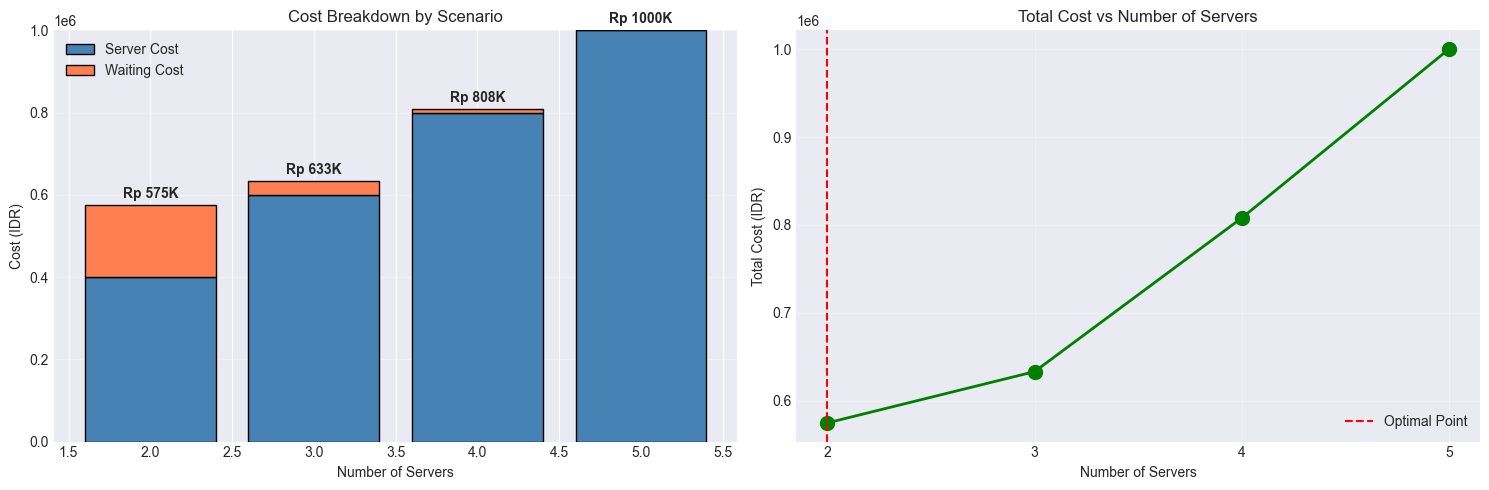


✓ Analisis cost-benefit berhasil!


In [9]:
# =============================================================================
# TAHAP 9: REKOMENDASI DAN COST-BENEFIT ANALYSIS
# =============================================================================

print("\n" + "="*60)
print("TAHAP 9: REKOMENDASI BISNIS")
print("="*60)

# Asumsi biaya
HOURLY_WAGE_PER_SERVER = 25000  # IDR per jam
CUSTOMER_LOSS_PER_MINUTE = 1000  # Asumsi kerugian per menit waiting
OPERATIONAL_HOURS = 8

print("\nAsumsi Cost-Benefit Analysis:")
print(f"- Gaji kasir: Rp {HOURLY_WAGE_PER_SERVER:,} per jam")
print(f"- Kerugian customer waiting: Rp {CUSTOMER_LOSS_PER_MINUTE:,} per menit")
print(f"- Jam operasional: {OPERATIONAL_HOURS} jam per hari")

# Hitung total cost untuk setiap skenario
for idx, row in results_df.iterrows():
    num_servers = row['num_servers']
    avg_wait = row['avg_waiting_time']
    total_customers = row['total_customers']
    
    # Biaya kasir
    server_cost = num_servers * HOURLY_WAGE_PER_SERVER * OPERATIONAL_HOURS
    
    # Kerugian dari waiting time
    waiting_cost = avg_wait * total_customers * CUSTOMER_LOSS_PER_MINUTE
    
    # Total cost
    total_cost = server_cost + waiting_cost
    
    results_df.at[idx, 'server_cost'] = server_cost
    results_df.at[idx, 'waiting_cost'] = waiting_cost
    results_df.at[idx, 'total_cost'] = total_cost

print("\n" + "="*60)
print("COST-BENEFIT ANALYSIS")
print("="*60)
print(results_df[['num_servers', 'avg_waiting_time', 'server_cost', 'waiting_cost', 'total_cost']].to_string(index=False))

# Cari skenario dengan total cost minimum
optimal_scenario = results_df.loc[results_df['total_cost'].idxmin()]

print("\n" + "="*60)
print("REKOMENDASI OPTIMAL")
print("="*60)
print(f"✓ Jumlah Server Optimal: {int(optimal_scenario['num_servers'])} kasir")
print(f"✓ Average Waiting Time: {optimal_scenario['avg_waiting_time']:.2f} menit")
print(f"✓ Total Cost: Rp {optimal_scenario['total_cost']:,.0f} per hari")
print(f"✓ Server Cost: Rp {optimal_scenario['server_cost']:,.0f}")
print(f"✓ Waiting Cost: Rp {optimal_scenario['waiting_cost']:,.0f}")

# Visualisasi Cost Analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Stacked Bar Chart - Cost Breakdown
x = results_df['num_servers']
server_costs = results_df['server_cost']
waiting_costs = results_df['waiting_cost']

axes[0].bar(x, server_costs, label='Server Cost', color='steelblue', edgecolor='black')
axes[0].bar(x, waiting_costs, bottom=server_costs, label='Waiting Cost', color='coral', edgecolor='black')
axes[0].set_xlabel('Number of Servers')
axes[0].set_ylabel('Cost (IDR)')
axes[0].set_title('Cost Breakdown by Scenario')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Tambahkan total cost di atas bar
for i, (servers, total) in enumerate(zip(x, results_df['total_cost'])):
    axes[0].text(servers, total + 10000, f'Rp {total/1000:.0f}K', ha='center', va='bottom', fontweight='bold')

# Plot 2: Line Chart - Total Cost
axes[1].plot(x, results_df['total_cost'], marker='o', linewidth=2, markersize=10, color='green')
axes[1].axvline(optimal_scenario['num_servers'], color='red', linestyle='--', label='Optimal Point')
axes[1].set_xlabel('Number of Servers')
axes[1].set_ylabel('Total Cost (IDR)')
axes[1].set_title('Total Cost vs Number of Servers')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(x)

plt.tight_layout()
plt.show()

print("\n✓ Analisis cost-benefit berhasil!")


## TAHAP 10: EXPORT HASIL UNTUK DEPLOYMENT

**Penjelasan:**
Menyiapkan hasil simulasi untuk aplikasi Streamlit:

**10.1 Save Model Parameters**
- Menyimpan parameter distribusi (λ, μ, σ)
- Menyimpan hasil simulasi per skenario
- Export ke JSON/pickle untuk deployment

**10.2 Create Summary Report**
- DataFrame ringkasan hasil semua skenario
- Export ke CSV untuk laporan
- Visualisasi yang akan digunakan di Streamlit

**File output:**
- `simulation_results.csv`: Ringkasan hasil
- `model_params.json`: Parameter model
- `figures/`: Folder berisi grafik-grafik

---

In [10]:
# =============================================================================
# TAHAP 10: EXPORT HASIL UNTUK DEPLOYMENT
# =============================================================================

print("\n" + "="*60)
print("TAHAP 10: EXPORT HASIL")
print("="*60)

# Simpan hasil simulasi
results_df.to_csv('simulation_results.csv', index=False)
print("✓ File 'simulation_results.csv' berhasil disimpan")

# Simpan parameter model
model_params = {
    'arrival_distribution': arrival_dist,
    'arrival_params': arrival_params,
    'service_distribution': service_dist,
    'service_params': service_params,
    'optimal_servers': int(optimal_scenario['num_servers']),
    'sim_duration': SIM_DURATION,
    'num_customers': NUM_CUSTOMERS
}

with open('model_params.json', 'w') as f:
    json.dump(model_params, f, indent=4)
print("✓ File 'model_params.json' berhasil disimpan")

# Summary report
print("\n" + "="*60)
print("SUMMARY REPORT")
print("="*60)
print(f"\n1. DATASET")
print(f"   - Total customers analyzed: {len(data)}")
print(f"   - Average inter-arrival time: {data['inter_arrival_time'].mean():.2f} minutes")
print(f"   - Average service time: {data['service_time'].mean():.2f} minutes")

print(f"\n2. DISTRIBUTION FITTING")
print(f"   - Inter-arrival: {arrival_dist.upper()}")
print(f"   - Service time: {service_dist.upper()}")

print(f"\n3. SIMULATION RESULTS")
print(f"   - Scenarios tested: {len(scenarios)}")
print(f"   - Simulation duration: {SIM_DURATION} minutes")
print(f"   - Customers simulated: {NUM_CUSTOMERS}")

print(f"\n4. OPTIMAL CONFIGURATION")
print(f"   - Number of servers: {int(optimal_scenario['num_servers'])}")
print(f"   - Average waiting time: {optimal_scenario['avg_waiting_time']:.2f} minutes")
print(f"   - Max queue length: {int(optimal_scenario['max_queue_length'])}")
print(f"   - Total daily cost: Rp {optimal_scenario['total_cost']:,.0f}")

print(f"\n5. BUSINESS IMPACT")
improvement = ((results_df.iloc[0]['avg_waiting_time'] - optimal_scenario['avg_waiting_time']) / 
               results_df.iloc[0]['avg_waiting_time'] * 100)
print(f"   - Waiting time reduction: {improvement:.1f}% (vs 2 servers)")
cost_savings = results_df.iloc[-1]['total_cost'] - optimal_scenario['total_cost']
print(f"   - Cost savings: Rp {cost_savings:,.0f} per hari (vs 5 servers)")

print("\n" + "="*60)
print("SIMULASI SELESAI!")
print("="*60)
print("\nFile yang dihasilkan:")
print("1. simulation_results.csv - Hasil simulasi semua skenario")
print("2. model_params.json - Parameter model untuk deployment")
print("\nSelanjutnya: Buat aplikasi Streamlit untuk deployment")
print("="*60)


TAHAP 10: EXPORT HASIL
✓ File 'simulation_results.csv' berhasil disimpan
✓ File 'model_params.json' berhasil disimpan

SUMMARY REPORT

1. DATASET
   - Total customers analyzed: 200
   - Average inter-arrival time: 2.36 minutes
   - Average service time: 3.09 minutes

2. DISTRIBUTION FITTING
   - Inter-arrival: GAMMA
   - Service time: GAMMA

3. SIMULATION RESULTS
   - Scenarios tested: 4
   - Simulation duration: 480 minutes
   - Customers simulated: 250

4. OPTIMAL CONFIGURATION
   - Number of servers: 2
   - Average waiting time: 0.90 minutes
   - Max queue length: 6
   - Total daily cost: Rp 574,983

5. BUSINESS IMPACT
   - Waiting time reduction: 0.0% (vs 2 servers)
   - Cost savings: Rp 425,017 per hari (vs 5 servers)

SIMULASI SELESAI!

File yang dihasilkan:
1. simulation_results.csv - Hasil simulasi semua skenario
2. model_params.json - Parameter model untuk deployment

Selanjutnya: Buat aplikasi Streamlit untuk deployment


## CATATAN PENGGUNAAN

1. **Instalasi Library:**
   ```bash
   pip install pandas numpy matplotlib seaborn scipy simpy
   ```

2. **Dataset:**
   - Download dari: https://www.kaggle.com/datasets/sanjeebtiwary/queue-waiting-time-prediction
   - Atau gunakan data sintetis yang disediakan dalam notebook

3. **Running Notebook:**
   - Jalankan cell secara berurutan dari atas ke bawah
   - Pastikan semua library terinstall
   - Sesuaikan path dataset jika diperlukan

4. **Interpretasi Hasil:**
   - Fokus pada trade-off antara waktu tunggu dan biaya operasional
   - Pilih skenario yang memberikan keseimbangan optimal

---

**Author**: Putra Aliansyah  
**NIM**: 301230041  
**Mata Kuliah**: Pemodelan dan Simulasi  
**Dosen**: Mohammad Bayu Anggara, S.Kom., M.Kom.